Logistic Regression

In [17]:
# import packages

import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
%matplotlib inline

Suppose that you are Stefano Panzeri and you want to classify if a candidate postdoc is worth hiring (i.e. classifying candidates you've never seen before into admitted/rejected) based on his/her results on two exams. You have historical data from previous candidates that you can use as a training set. For each training example, you have the applicant's scores on two exams and the admissions decision.

Recall from Bishop chapter 4 (see slides): 

**Linear Regression**: prediction of a continuous variable $t$ as $ t(\textbf{x}) = \textbf{w}^T * \pmb{\phi}(\textbf{x})$

**Logistic regression**: prediction of a discrete variable $t$ (here, binary). You start with a model for a continuous variable $h$ between 0-1, as $h(\textbf{x}) = \sigma(\textbf{w}^T * \pmb{\phi}(\textbf{x}))$, which is just a GLM $h(\textbf{x}) = f(\textbf{w}^T * \pmb{\phi}(\textbf{x}))$ with $f=\sigma$ being the logistic activation function (this defines the name logistic) and the function $\pmb{\phi}(\textbf{x})$, called the basis function, could be a nonlinear transformation of $x$ or just the identity function, $\pmb{\phi}(\textbf{x})=x$, if one looks for a discrimination boundary that is linear in $\textbf{x}$. 

$\sigma$ converts a continuous input into a value between zero and one, as the figure below shows.

In [18]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

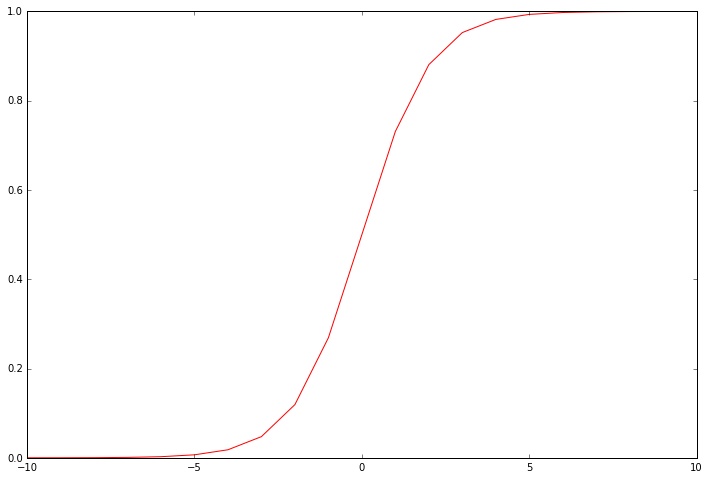

In [19]:
nums = np.arange(-10, 10, step=1)

fig, ax = plt.subplots(figsize=(12,8))  
ax.plot(nums, sigmoid(nums), 'r')  

Thus, the value of $h$ can be interpreted as the probability of one of the classes of $t$, $P(C_1 | x)$ in Bishop's notation. Actually, the logistic regression framework can be obtained by just applying Bayes to get a expression of $P(C_1 | x)$:

$$P(C_1 | x)=\frac{P(x|C_1)P(C_1)}{P(x|C_1)P(C_1)+P(x|C_2)P(C_2)} = \frac{1}{1+\exp(-a)} = \sigma(a) $$

Where

$$a=\ln\frac{P(x|C_1)P(C_1)}{P(x|C_2)P(C_2)}$$


Using this probability along with a threshold value, we can obtain a discrete (here, binary) label prediction for the target variable $t$. 

**Now we get data for exercise**: the dependent variable $t$ is Admitted or not, the two independent variables are the scores for Exam 1 and Exam 2. Note that we assume that the two scores are independent from each other.

In [20]:
import os  
path = os.getcwd() + '/data/dataLogisticRegressionEx.txt'  
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])  
data.head()  

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Visualize how t covaries with independent variables

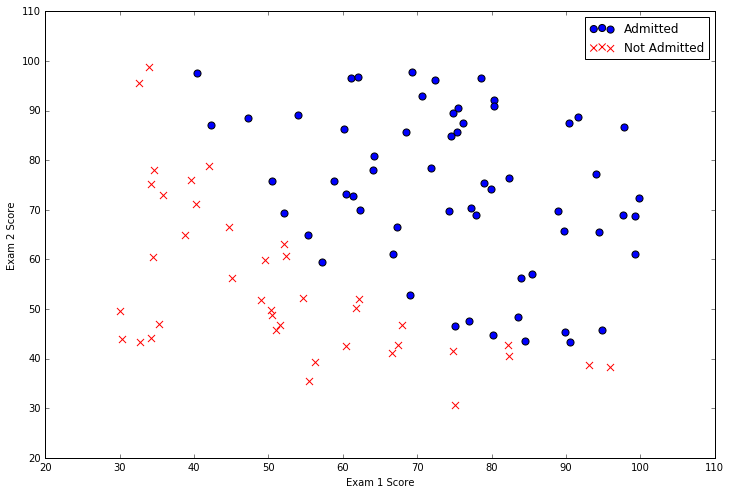

In [21]:
positive = data[data['Admitted'].isin([1])]  
negative = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='b', marker='o', label='Admitted')  
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')  
ax.legend()  
ax.set_xlabel('Exam 1 Score')  
ax.set_ylabel('Exam 2 Score')  

From this plot we can see that **there’s a nearly linear decision boundary**. It curves a bit so we can’t classify all of the examples correctly using a straight line, but we should be able to get pretty close.

Now we need to **implement logistic regression** so we can train a model to find the optimal decision boundary and make class predictions. 

The logistic regression hypothesis is

$$ h_w(\textbf{x}) = \sigma(\textbf{w}^T*\textbf{x})$$

where we have made explicit the dependence of the model on $w$, the set of parameters that has to be optimized to fit the training set.

Our next step is to write a **cost function** that evaluates the performance of the model on the training data $\{t^{(i)}\}_{\{i=1,...,N\}}$ ($N$ observations) given a set of model parameters. Here, define an error function by taking the negative logarithm of the likelihood, which gives the cross-entropy error function in the form (eq. 4.90 in Bishop's book):

$$E(w) = \ln P(\textbf{t}|w) = -\sum_{i=1}^N [t^{(i)} \ln(\sigma(a^{(i)})) + (1 - t^{(i)}) \ln(1 -\sigma(a^{(i)}))]$$

Where $a^{(i)}=\textbf{w}^T\pmb{\phi}(\textbf{x})$

In [22]:
def cost(w, X, t):  
    w = np.matrix(w)
    X = np.matrix(X)
    t = np.matrix(t)
    first = np.multiply(-t, np.log(sigmoid(X * w.T)))
    second = np.multiply((1 - t), np.log(1 - sigmoid(X * w.T)))
    return np.sum(first - second) 

Note that $J(w)$, i.e. the output of $cost$, is a single scalar value, which is the sum over training samples of the “error” quantified as a function of the difference between the class probability assigned by the model $h_w(x^{(i)})$ and the true label of the example $t^{(i)}$.

Now, some technical setup for calling the functions right

In [23]:
# add a ones column - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

# set X (training data) and t (target variable)
cols = data.shape[1]  
X = data.iloc[:,0:cols-1]  
t = data.iloc[:,cols-1:cols]

# convert to numpy arrays and initalize the parameter array w
X = np.array(X.values)  
t = np.array(t.values)  
w = np.zeros(3)  

# check that matrices above have the right shape
X.shape, w.shape, t.shape 

((100, 3), (3,), (100, 1))

In the code above, w was initialized as a vector w^0 = (0, 0, 0). Let's compute J(w^0)

In [24]:
cost(w, X, t)

69.314718055994533

Now we write a function that computes **the gradient** $\frac{\partial E(w)}{\partial w_k}$ ($k$ is the number of dimensions of the vector $w$) to figure out how to change $w$ to minimize the error $E(w)$ on the training data. The implementation is an iterative gradient descent algorithm that, at each training iteration, updates $w$ in a way that’s guaranteed to move it in a direction that reduces $E(w)$ (the training error or the cost as defined above). This is easily done here, because the cost function is differentiable:

$$ \frac{\partial E(w)}{\partial w_k} = \sum_{i=1}^N (h_w(\sigma(a^{(i)}) - t^{(i)})\pmb{\phi}(\textbf{x}^{(i)}) $$

Where, again Where $a^{(i)}=\textbf{w}^T\pmb{\phi}(\textbf{x}^{(i)})$.

Let's implement this function:

In [25]:
def gradient(w, X, t):  
    w = np.matrix(w)
    X = np.matrix(X)
    t = np.matrix(t)

    parameters = int(w.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * w.T) - t

    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) 

    return grad

Now we perform **gradient descent**, and thus minimize the error (cost) function $E(w)$, with the following implementation.

In [28]:
import scipy.optimize as opt  
result = opt.fmin_tnc(func=cost, x0=w, fprime=gradient, args=(X, t))  
cost(result[0], X, t)  

20.349770158947457

**We now have the optimal model parameters $\bar{w}$ for our dataset**. Hence, we can write a function that will output predictions for the training dataset $\{t^{(i)}\}_{\{i=1,...,N\}}$ using our learned parameters $\bar{w}$, and use this function to score the training accuracy of our classifier.

In [29]:
def predict(w, X):  
    probability = sigmoid(X * w.T)
    return [1 if x >= 0.5 else 0 for x in probability]

w_min = np.matrix(result[0])  
predictions = predict(w_min, X)  
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, t)] 

Print outcome accuracy in two different ways (kudos to Yann Zerlaut for pointing out that dictionaries, "as results below", should always be used in python - similar to structures in matlab).

In [32]:
results = {}
results['accuracy'] = (sum(map(int, correct)) / len(correct))*100
print("accuracy = %(accuracy).1f %%" % results) 
np.savez('results.npz', **results)
results = dict(np.load('results.npz'))
print(results)

accuracy = 89.0 %
{'accuracy': array(89.0)}


However you print it, the accuracy on the training set turns out to be $89 \%$. Keep in mind that this is training set accuracy though. We didn't keep a hold-out set or use cross-validation to get a true approximation of the accuracy so this number is likely higher than its true performance.

Finally, let's plot the decision boundary (see https://stackoverflow.com/questions/42704698/logistic-regression-plotting-decision-boundary-from-theta) 
(to do: plot of posterior probabilities from https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression).

In [ ]:
def posterior(w, X):  
    probability = sigmoid(X * w.T)
    return probability

w_min = np.matrix(result[0])  
posteriors = posterior(w_min, X)  
posteriors.shape, X.shape

In [ ]:
xx = np.mgrid[0:100:1]

f, ax = plt.subplots(figsize=(8, 6))
y_class=[1 if x >= 0.5 else 0 for x in y];

ax.scatter(X[:,1], X[:, 2], c=y_class, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
decision_boundary = -(np.array(w_min)[:, 1]*np.array(xx)  + np.array(w_min)[:, 0])/np.array(w_min)[:, 2]; 
ax.plot(xx, decision_boundary, 'r--', label='Decision boundary')
ax.set(aspect="equal",
       #xlim=(0, 100), ylim=(0, 100),
       xlabel="$Exam 1$", ylabel="$Exam 2$")

Materials and links

http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-3/

https://github.com/jdwittenauer/ipython-notebooks/blob/master/exercises/ML/ex2.pdf

https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression

http://www.win-vector.com/blog/2011/09/the-simpler-derivation-of-logistic-regression/